In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter, OrderedDict
import nltk
import re
from copy import deepcopy
flatten = lambda l: [item for sublist in l for item in sublist]

import matplotlib.pyplot as plt
import itertools
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split

#random.seed(1024)
%matplotlib inline

pd.options.display.max_rows=1000


In [2]:
USE_CUDA = torch.cuda.is_available()
gpus = [0]
torch.cuda.set_device(gpus[0])

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [3]:
def getBatch_MultiHead(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [4]:
def pad_to_batch_MultiHead(batch):
    x_text, x_ref_, y, x_text_actual = zip(*batch)
    x_ref = [Variable(FloatTensor(x)).view(1,-1) for x in x_ref_]
    max_x_text = max([s.size(1) for s in x_text])
    x_p_text = []
    x_p_text_actual = []
    for i in range(len(batch)):
        if x_text[i].size(1) < max_x_text:
            x_p_text.append(torch.cat([x_text[i], Variable(LongTensor([word2index['<PAD>']] * (max_x_text - x_text[i].size(1)))).view(1, -1)], 1))
        else:
            x_p_text.append(x_text[i])
        x_p_text_actual.append(x_text_actual)
    return torch.cat(x_p_text), torch.cat(x_ref), torch.cat(y).view(-1), x_p_text_actual

In [5]:
def prepare_sequence(seq, to_index):
    idxs = list(map(lambda w: to_index[w] if to_index.get(w) is not None else to_index["<UNK>"], seq))
    return Variable(LongTensor(idxs))

## Data Loading and Pre-processing

In [6]:
train_data = pd.read_pickle('inspire_data_with_reference_fractions_and_num_references/inspire_data_augmented_train_corrected.df')
test_data = pd.read_pickle('inspire_data_with_reference_fractions_and_num_references/inspire_data_augmented_test_corrected.df')

In [7]:
means = train_data.iloc[:,:-2].mean().values
stds = train_data.iloc[:,:-2].std().values

train_data.iloc[:,:-2] = (train_data.iloc[:,:-2] - means) / stds
test_data.iloc[:,:-2] = (test_data.iloc[:,:-2] - means) / stds

In [8]:
X_train = list(train_data['text'])
X_train_core1 = list(train_data['core_references_fraction_first_order'])
X_train_core2 = list(train_data['core_references_fraction_second_order'])
X_train_noncore1 = list(train_data['noncore_references_fraction_first_order'])
X_train_noncore2 = list(train_data['noncore_references_fraction_second_order'])
X_train_num_refs1 = list(train_data['total_first_order_references'])
X_train_num_refs2 = list(train_data['total_second_order_references'])
y_train = list(train_data['labels'])

In [9]:
X_test = list(test_data['text'])
X_test_core1 = list(test_data['core_references_fraction_first_order'])
X_test_core2 = list(test_data['core_references_fraction_second_order'])
X_test_noncore1 = list(test_data['noncore_references_fraction_first_order'])
X_test_noncore2 = list(test_data['noncore_references_fraction_second_order'])
X_test_num_refs1 = list(test_data['total_first_order_references'])
X_test_num_refs2 = list(test_data['total_second_order_references'])
y_test = list(test_data['labels'])

In [10]:
# Get the class weights
rejected_count = y_train.count(0)
noncore_count = y_train.count(1)
core_count = y_train.count(2)

total_count = len(y_train)

inverse_rejected_fraction = total_count / rejected_count
inverse_noncore_fraction = total_count / noncore_count
inverse_core_fraction = total_count / core_count 

sum_fractions = inverse_rejected_fraction + inverse_noncore_fraction + inverse_core_fraction

# Specify the class weights (for the loss function specified later)
class_weights = torch.cuda.FloatTensor((inverse_rejected_fraction/sum_fractions,
                                        inverse_noncore_fraction/sum_fractions,
                                        inverse_core_fraction/sum_fractions))

In [11]:
class_weights = class_weights / class_weights[1]
print(class_weights)

tensor([1.8749, 1.0000, 1.1123], device='cuda:0')


##### Lowercase all text

In [12]:
# Lowercase the entire text corpora
X_train = [x.lower() for x in X_train]
X_test = [x.lower() for x in X_test]

##### Remove punctuation

In [13]:
punc_to_remove = str('!"%&\'()*+,./:;<=>?@[\\]^_`{|}~')
for i, x in enumerate(X_train):
    X_train[i] = ' '.join(word.strip(punc_to_remove) for word in x.split())
for i, x in enumerate(X_test):
    X_test[i] = ' '.join(word.strip(punc_to_remove) for word in x.split())

##### Num Masking

In [14]:
for i, x in enumerate(X_train):
    X_train[i] = re.sub('\d+', '<NUM>', x)
for i, x in enumerate(X_test):
    X_test[i] = re.sub('\d+', '<NUM>', x)

##### Replace Latex Equations

In [15]:
for i, _ in enumerate(X_train):
    f = re.search(r"(.+(?P<name>\$.+\$).+)+", X_train[i])
    while f is not None:
        X_train[i] = re.sub(re.escape(f.group('name')), '<FORMULA>', X_train[i])
        f = re.search(r"(.+(?P<name>\$.+\$).+)+", X_train[i])
for i, _ in enumerate(X_test):
    f = re.search(r"(.+(?P<name>\$.+\$).+)+", X_test[i])
    while f is not None:
        X_test[i] = re.sub(re.escape(f.group('name')), '<FORMULA>', X_test[i])
        f = re.search(r"(.+(?P<name>\$.+\$).+)+", X_test[i])

##### Tokenize the text

In [16]:
X_train = [nltk.word_tokenize(x) for x in X_train]
X_test = [nltk.word_tokenize(x) for x in X_test]

##### Lemmatize the text

In [17]:
wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
X_train = [[wordnet_lemmatizer.lemmatize(word) for word in x] for x in X_train]
X_test = [[wordnet_lemmatizer.lemmatize(word) for word in x] for x in X_test]

##### Build vocabulary

In [18]:
vocab = list(set(flatten(X_train)))
print(len(vocab))

245674


In [19]:
print(len(set(y_train))) # Number of classes

3


In [20]:
word2index={'<PAD>': 0, '<UNK>': 1}

for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)
        
index2word = {v:k for k, v in word2index.items()}

target2index = {}

for cl in set(y_train):
    if target2index.get(cl) is None:
        target2index[cl] = len(target2index)

index2target = {v:k for k, v in target2index.items()}

In [21]:
pickle.dump(word2index, open('inspire_data_with_reference_fractions_and_num_references/word2index.pkl', 'wb'))
pickle.dump(target2index, open('inspire_data_with_reference_fractions_and_num_references/target2index.pkl', 'wb'))
pickle.dump(X_train, open('inspire_data_with_reference_fractions_and_num_references/X_train.pkl', 'wb'))
pickle.dump(X_test, open('inspire_data_with_reference_fractions_and_num_references/X_test.pkl', 'wb'))

In [ ]:
word2index = pickle.load(open('inspire_data_with_reference_fractions_and_num_references/word2index.pkl', 'rb'))
target2index = pickle.load(open('inspire_data_with_reference_fractions_and_num_references/target2index.pkl', 'rb'))
X_train = pickle.load(open('inspire_data_with_reference_fractions_and_num_references/X_train.pkl', 'rb'))
X_test = pickle.load(open('inspire_data_with_reference_fractions_and_num_references/X_test.pkl', 'rb'))

In [22]:
def zip_data(text, core1, core2, noncore1, noncore2, num_refs1, num_refs2, y, actual_text):
    X_p_text, X_p_ref, y_p, X_text_actual = [], [], [], []
    for pair in zip(text, core1, core2, noncore1, noncore2, num_refs1, num_refs2, y, actual_text):
        X_p_text.append(prepare_sequence(pair[0], word2index).view(1, -1))
        X_p_ref.append(np.array([pair[1], pair[2], pair[3], pair[4], pair[5], pair[6]]))
        y_p.append(Variable(LongTensor([target2index[pair[7]]])).view(1, -1))
        X_text_actual.append(pair[8])
        
    return list(zip(X_p_text, X_p_ref, y_p, X_text_actual))

In [23]:
training_data = zip_data(X_train, X_train_core1, X_train_core2, X_train_noncore1, 
                         X_train_noncore2, X_train_num_refs1, X_train_num_refs2, 
                         y_train, train_data.text)
testing_data = zip_data(X_test, X_test_core1, X_test_core2, X_test_noncore1, 
                         X_test_noncore2, X_test_num_refs1, X_test_num_refs2, 
                         y_test, test_data.text)

##### Load pre-trained Word Vectors

In [24]:
import gensim

In [171]:
model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)

In [172]:
len(model.index2word)

3000000

In [211]:
y_list, n_list = [], []
for key in word2index.keys():
    try:
        model.get_vector(key)
        y_list.append(key)
    except:
        n_list.append(key)
(len(y_list), len(n_list))

In [214]:
pretrained = []

for key in word2index.keys():
    try:
        pretrained.append(model.get_vector([word2index[key]]))
    except:
        pretrained.append(np.random.randn(300))
        
pretrained_vectors = np.vstack(pretrained)

## Train

In [230]:
EPOCH = 2
BATCH_SIZE = 64
KERNEL_SIZES = [3,4,5,6]
KERNEL_DIM = 200
DROPOUT = 0.2
LR = 0.001
REF_FC_LAYER1_DIM = 200
REF_FC_LAYER2_DIM = 100

In [231]:
class  CNN_Classifier_MultiHead(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_size, kernel_dim=100, kernel_sizes=(3, 4, 5), dropout=0.5,
                 ref_fc_layer1_dim=200, ref_fc_layer2_dim=100):
        super(CNN_Classifier_MultiHead,self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([nn.Conv2d(1, kernel_dim, (K, embedding_dim)) for K in kernel_sizes])
        self.bn_conv = nn.BatchNorm2d(200)

        # FC Layer for the reference fractions
        self.fc_reference_fraction1 = nn.Linear(6, ref_fc_layer1_dim)
        self.bn_fcr1 = nn.BatchNorm1d(ref_fc_layer1_dim)
        self.fc_reference_fraction2 = nn.Linear(ref_fc_layer1_dim, ref_fc_layer2_dim)
        self.bn_fcr2 = nn.BatchNorm1d(ref_fc_layer2_dim)
        
        # kernal_size = (K,D) 
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(kernel_sizes) * kernel_dim + ref_fc_layer2_dim, output_size)
    
    
    def init_weights(self, pretrained_word_vectors, is_static=False):
        self.embedding.weight = nn.Parameter(torch.from_numpy(pretrained_word_vectors).float())
        if is_static:
            self.embedding.weight.requires_grad = False


    def forward(self, text_inputs, reference_fraction_inputs, is_training=False):
        text_inputs = self.embedding(text_inputs).unsqueeze(1) # (B,1,T,D)
        text_inputs = [F.relu(self.bn_conv(conv(text_inputs))).squeeze(3) for conv in self.convs] #[(N,Co,W), ...]*len(Ks)
        text_inputs = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in text_inputs] #[(N,Co), ...]*len(Ks)

        concated = torch.cat(text_inputs, dim=1)
        
        reference_fraction_out = self.bn_fcr1(self.fc_reference_fraction1(reference_fraction_inputs))
        reference_fraction_out2 = self.bn_fcr2(self.fc_reference_fraction2(reference_fraction_out))
        super_concatenated = torch.cat((concated, reference_fraction_out2), dim=1)

        if is_training:
            super_concatenated = self.dropout(super_concatenated) # (N,len(Ks)*Co)
        out = self.fc(super_concatenated)
        return F.log_softmax(out,1)

In [232]:
model = CNN_Classifier_MultiHead(len(word2index), 300, len(target2index), KERNEL_DIM, KERNEL_SIZES, dropout=DROPOUT,
                                ref_fc_layer1_dim=REF_FC_LAYER1_DIM, ref_fc_layer2_dim=REF_FC_LAYER2_DIM)
model.init_weights(pretrained_vectors) # initialize embedding matrix using pretrained vectors

if USE_CUDA:
    model = model.cuda()
    
loss_function = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = optim.Adam([
#     {'params': model.embedding.parameters()},
#     {'params': model.convs.parameters()},
#     {'params': model.dropout.parameters()}, 
#     {'params': model.fc.parameters()},
#     {'params': model.bn_conv.parameters()},
#     {'params': model.bn_fcr1.parameters()},
#     {'params': model.bn_fcr2.parameters()},
#     {'params': model.fc_reference_fraction1.parameters(), 'lr': 0.0001},
#     {'params': model.fc_reference_fraction2.parameters(), 'lr': 0.0001}
# ], lr=LR)
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

In [233]:
print(model)

CNN_Classifier_MultiHead(
  (embedding): Embedding(245676, 300)
  (convs): ModuleList(
    (0): Conv2d(1, 200, kernel_size=(3, 300), stride=(1, 1))
    (1): Conv2d(1, 200, kernel_size=(4, 300), stride=(1, 1))
    (2): Conv2d(1, 200, kernel_size=(5, 300), stride=(1, 1))
    (3): Conv2d(1, 200, kernel_size=(6, 300), stride=(1, 1))
  )
  (bn_conv): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_reference_fraction1): Linear(in_features=6, out_features=200, bias=True)
  (bn_fcr1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_reference_fraction2): Linear(in_features=200, out_features=100, bias=True)
  (bn_fcr2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2)
  (fc): Linear(in_features=900, out_features=3, bias=True)
)


In [234]:
def train_model(train_data, model, loss_function, epoch):
    '''
    Trains the model for one epoch
    '''
    
    model.train()
    avg_loss = []
    avg_train_acc = []
    
    for i, batch in enumerate(getBatch_MultiHead(BATCH_SIZE, train_data)):
        text_inputs, reference_fraction_inputs, targets, _ = pad_to_batch_MultiHead(batch)
        
        model.zero_grad()
        preds = model(text_inputs, reference_fraction_inputs, True)
        
        loss = loss_function(preds, targets)
        loss.backward()
        
        optimizer.step()
        
        train_acc = (sum(preds.max(1)[1] == targets).item() / BATCH_SIZE) * 100
        
        if i % 100 == 0:
            print('TRAIN [Epoch : {}/{}][Batch: {}] Batch Train Loss: {}, Batch Train Accuracy: {}'.format(epoch, EPOCH, 
                                                                                                i, loss.item(),
                                                                                                train_acc))
    
        avg_loss.append(loss.item())
        avg_train_acc.append(train_acc)
        
    avg_loss = np.mean(avg_loss)
    avg_train_acc = np.mean(avg_train_acc)

    return avg_loss, avg_train_acc

def validate(val_data, model, loss_function, epoch):
    
    model.eval()
    avg_loss = []
    avg_test_acc = []
    
    for i, batch in enumerate(getBatch_MultiHead(BATCH_SIZE, val_data)):
        text_inputs, reference_fraction_inputs, targets, _ = pad_to_batch_MultiHead(batch)
        
        preds = model(text_inputs, reference_fraction_inputs, False)
        
        loss = loss_function(preds, targets)
        
        test_acc = (sum(preds.max(1)[1] == targets).item() / BATCH_SIZE) * 100
        
        if i % 100 == 0:
            print('VAL [Epoch : {}/{}][Batch: {}] Batch Test Loss: {}, Batch Test Accuracy: {}'.format(epoch, EPOCH, 
                                                                                                i, loss.item(),
                                                                                                test_acc))
    
        avg_loss.append(loss.item())
        avg_test_acc.append(test_acc)
        
    avg_loss = np.mean(avg_loss)
    avg_test_acc = np.mean(avg_test_acc)

    return avg_loss, avg_test_acc

In [235]:
train_loss, train_acc, val_loss, val_acc = [], [], [], []
for epoch in range(EPOCH):
    
    scheduler.step()
    
    print('<<<<<<<<<<<<<TRAINING>>>>>>>>>>>>')
    epoch_train_loss, epoch_train_acc = train_model(training_data, model, loss_function, epoch)
    print('[TRAIN] EPOCH: {}, Loss: {}, Accuracy: {}'.format(epoch, epoch_train_loss, epoch_train_acc))
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)
    
    print('<<<<<<<<<<<<< VALIDATING >>>>>>>>>>>>')
    epoch_val_loss, epoch_val_acc = validate(testing_data, model, loss_function, epoch)
    print('[VAL] EPOCH: {}, Loss: {}, Accuracy: {}'.format(epoch, epoch_val_loss, epoch_val_acc))    
    val_loss.append(epoch_val_loss)
    val_acc.append(epoch_val_acc)

<<<<<<<<<<<<<TRAINING>>>>>>>>>>>>
TRAIN [Epoch : 0/2][Batch: 0] Batch Train Loss: 1.3612946271896362, Batch Train Accuracy: 42.1875
TRAIN [Epoch : 0/2][Batch: 100] Batch Train Loss: 0.5697987675666809, Batch Train Accuracy: 71.875
TRAIN [Epoch : 0/2][Batch: 200] Batch Train Loss: 0.7323276400566101, Batch Train Accuracy: 70.3125
TRAIN [Epoch : 0/2][Batch: 300] Batch Train Loss: 0.4415699243545532, Batch Train Accuracy: 89.0625
TRAIN [Epoch : 0/2][Batch: 400] Batch Train Loss: 0.5529939532279968, Batch Train Accuracy: 79.6875
TRAIN [Epoch : 0/2][Batch: 500] Batch Train Loss: 0.43316006660461426, Batch Train Accuracy: 78.125
TRAIN [Epoch : 0/2][Batch: 600] Batch Train Loss: 0.7639486193656921, Batch Train Accuracy: 68.75
TRAIN [Epoch : 0/2][Batch: 700] Batch Train Loss: 0.40155908465385437, Batch Train Accuracy: 82.8125
TRAIN [Epoch : 0/2][Batch: 800] Batch Train Loss: 0.4137277603149414, Batch Train Accuracy: 79.6875
TRAIN [Epoch : 0/2][Batch: 900] Batch Train Loss: 0.6128589510917664, 

VAL [Epoch : 1/2][Batch: 100] Batch Test Loss: 0.26908424496650696, Batch Test Accuracy: 89.0625
VAL [Epoch : 1/2][Batch: 200] Batch Test Loss: 0.31672176718711853, Batch Test Accuracy: 89.0625
VAL [Epoch : 1/2][Batch: 300] Batch Test Loss: 0.35423457622528076, Batch Test Accuracy: 84.375
VAL [Epoch : 1/2][Batch: 400] Batch Test Loss: 0.2064998596906662, Batch Test Accuracy: 90.625
VAL [Epoch : 1/2][Batch: 500] Batch Test Loss: 0.19309790432453156, Batch Test Accuracy: 92.1875
VAL [Epoch : 1/2][Batch: 600] Batch Test Loss: 0.2323930561542511, Batch Test Accuracy: 93.75
VAL [Epoch : 1/2][Batch: 700] Batch Test Loss: 0.2929430305957794, Batch Test Accuracy: 85.9375
VAL [Epoch : 1/2][Batch: 800] Batch Test Loss: 0.35956263542175293, Batch Test Accuracy: 82.8125
[VAL] EPOCH: 1, Loss: 0.28058172875177967, Accuracy: 87.94617259174312


#### Make loss and accuracy plots

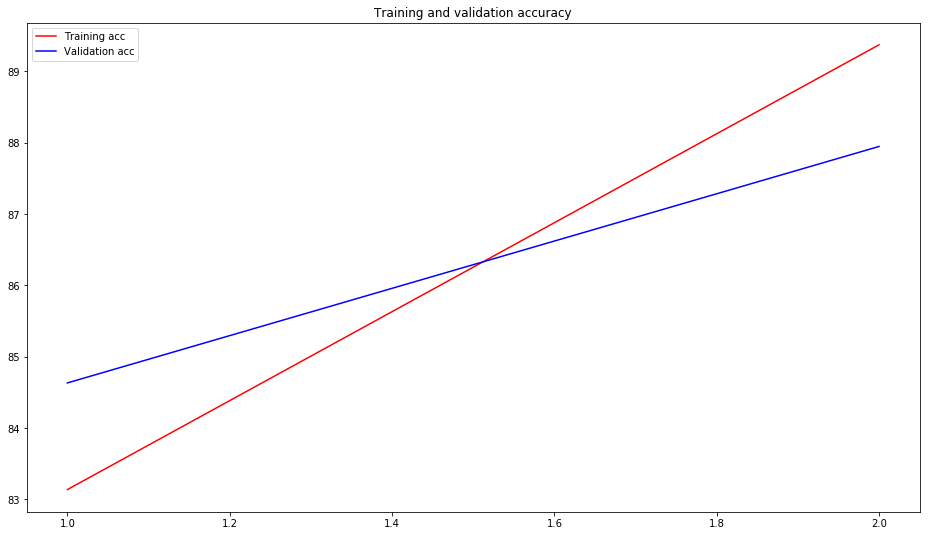

In [236]:
# Accuracy
epochs = range(1, EPOCH + 1)

plt.figure(figsize=(16, 9))
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

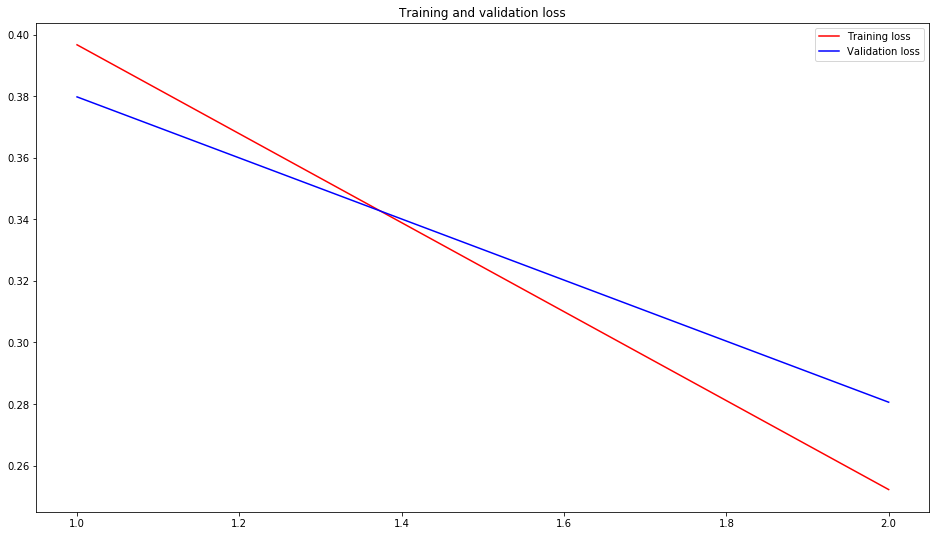

In [237]:
# Loss

plt.figure(figsize=(16, 9))
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Evaluate on validation set

accuracy = 0

for test in val_data:
    pred = model(test[0], test[1], False).max(1)[1]
    pred = pred.data.tolist()[0]
    target = test[1].data.tolist()[0][0]
    if pred == target:
        accuracy += 1

print(accuracy/len(val_data) * 100)

In [238]:
if 'Y_VAL' in locals():
    del Y_VAL, Y_VAL_PREDS

encoded_text = []
actual_text = []
ref_fracs = []
labels = []
predicted = []

for data in getBatch_MultiHead(50, testing_data):
    text_inputs, ref_inputs, targets, text_actual = pad_to_batch_MultiHead(data)

    y_val_pred = model(text_inputs, ref_inputs, False)
    preds = y_val_pred.max(1)[1]
    
    if 'Y_VAL' in locals():
        Y_VAL = torch.cat((Y_VAL, targets), 0)
        Y_VAL_PREDS = torch.cat((Y_VAL_PREDS, preds), 0)
    else:
        Y_VAL = targets
        Y_VAL_PREDS = preds
    
    encoded_text.append(text_inputs)
    actual_text.append(text_actual)
    ref_fracs.append(ref_inputs)
    labels.append(targets)
    predicted.append(preds)

In [239]:
enc_text = [text.cpu().numpy() for text_list in encoded_text for text in text_list]
raw_text = [text for text_list in actual_text for text in text_list[0]]
ref_fractions = [tuple(ref_f.cpu().numpy()) for sublist in ref_fracs for ref_f in sublist]
pd_labels = [l.item() for sublist in labels for l in sublist]
pd_predicted = [p.item() for sublist in predicted for p in sublist]

In [240]:
from sklearn.metrics import confusion_matrix

In [241]:
conf_mat = confusion_matrix(pd_labels, pd_predicted, labels = [0, 1, 2])

In [242]:
# funtion to plot confusion matrices, will be needed later

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    else:
        print('Confusion matrix, without normalization')
        plt.imshow(cm, interpolation='nearest', cmap=cmap)

    print(cm)
    
    
    plt.title(title)
    plt.colorbar( )
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.97768931 0.01741727 0.00489342]
 [0.09251501 0.79695936 0.11052563]
 [0.01956976 0.06531346 0.91511679]]


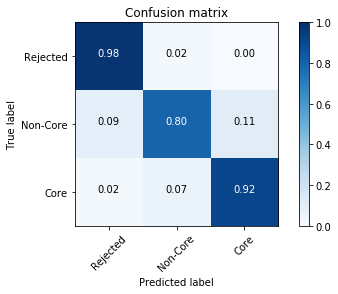

In [243]:
plt.figure()
plot_confusion_matrix(conf_mat, ['Rejected', 'Non-Core', 'Core'], normalize=True)
plt.show()

Confusion matrix, without normalization
[[11788   210    59]
 [ 2142 18452  2559]
 [  403  1345 18845]]


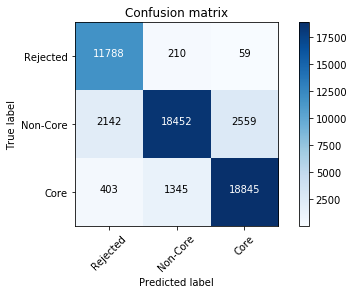

In [244]:
plt.figure()
plot_confusion_matrix(conf_mat, ['Rejected', 'Non-Core', 'Core'], normalize=False)
plt.show()

### Look at the mismatches

In [55]:
predictions = pd.DataFrame(data={'text': raw_text, 'encoded_text': enc_text, 'ref_fractions': ref_fractions, 'label': pd_labels, 'pred': pd_predicted})

In [ ]:
predictions.to_pickle('inspire_data_with_reference_fractions_and_num_references/predictions_custom_preprocessing.pkl')

In [56]:
predictions.head()

,text,encoded_text,ref_fractions,label,pred
0,Neutron orbit sizes in the isotopes of tin <EN...,"[17109, 238693, 38823, 232019, 174713, 14067, ...","(-0.50756806, -0.43275675, 2.602756, 1.2361034...",1,1
1,Construction of hyperbolic Riemann surfaces wi...,"[242367, 36948, 157865, 94049, 222424, 178445,...","(-0.5821015, -0.62245136, -0.5509232, -0.63074...",0,0
2,Correlated Electron-Nuclear Dynamics with Cond...,"[235062, 172846, 135452, 178445, 72694, 222565...","(-0.5821015, -0.62245136, -0.5509232, -0.63074...",0,0
3,Dependence of halo bias on mass and environmen...,"[214412, 36948, 138296, 19148, 233908, 62786, ...","(-0.5821015, -0.53982633, 4.1853714, 3.706151,...",1,1
4,Noise and Periodic Modulations in Neural Excit...,"[71353, 15913, 214773, 228443, 232019, 120110,...","(-0.50570476, -0.4505913, -0.5509232, -0.03649...",0,0


In [58]:
predictions[(predictions.label == 2) &  (predictions.pred == 0)]

,text,encoded_text,ref_fractions,label,pred
340,Clebsch–Gordan coefficients of discrete groups...,"[181307, 73104, 36948, 57848, 243781, 232019, ...","(-0.5821015, -0.62245136, -0.5509232, -0.63074...",2,0
2622,Untangling knots via reaction-diffusion dynami...,"[148204, 242901, 210225, 190485, 135452, 36948...","(-0.07278954, 1.212665, -0.5509232, 0.27574164...",2,0
3401,Evolution and metric signature change of maxim...,"[56144, 15913, 221088, 153849, 150020, 36948, ...","(-0.5821015, -0.62245136, -0.5509232, -0.63074...",2,0
3415,Asymptotic expansions of the Witten-Reshetikhi...,"[155385, 194127, 36948, 174713, 161247, 123343...","(-0.5294141, -0.3884906, -0.37943667, -0.36108...",2,0
3472,Comparing Jupiter interior structure models to...,"[30232, 149083, 244818, 226361, 11466, 8019, 1...","(-0.5821015, -0.62245136, 0.609469, 0.7005839,...",2,0
3951,New family of potentials with analytical twist...,"[161778, 237371, 36948, 110460, 178445, 214147...","(-0.5821015, -0.62245136, -0.5509232, -0.63074...",2,0
4303,On integral representations and asymptotics of...,"[233908, 136846, 83981, 15913, 168694, 36948, ...","(-0.24256021, 0.3490553, -0.5509232, 0.0101637...",2,0
5878,On the unipotence of autoequivalences of toric...,"[233908, 174713, 1, 36948, 110810, 36948, 1898...","(-0.5821015, -0.62245136, -0.5509232, -0.63074...",2,0
6505,Solving DWF Dirac Equation Using Multisplittin...,"[238404, 14684, 126084, 1139, 76763, 35374, 12...","(-0.5821015, -0.62245136, -0.5509232, -0.63074...",2,0
6509,Unconstrained Summoning <ENDTITLE> We define a...,"[18786, 1, 163507, 224290, 22416, 138034, 1, 2...","(-0.5821015, -0.62245136, -0.5509232, -0.63074...",2,0


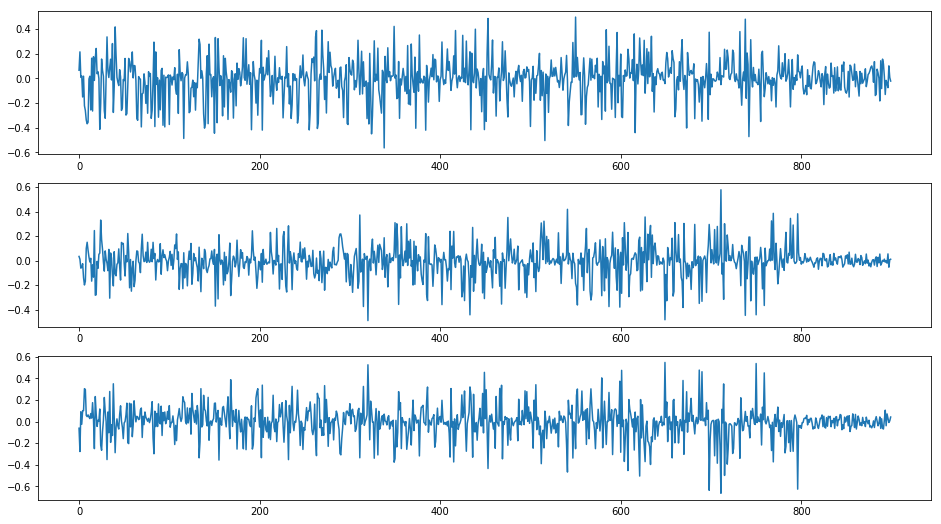

In [167]:
plt.figure(figsize=(16, 9))
plt.subplot(311)
plt.plot(model.fc.weight.cpu().detach().numpy().T[:,0])
plt.subplot(312)
plt.plot(model.fc.weight.cpu().detach().numpy().T[:,1])
plt.subplot(313)
plt.plot(model.fc.weight.cpu().detach().numpy().T[:,2])

In [ ]:
plt.figure(figsize=(16, 9))
plt.subplot(611)
plt.plot(model.fc_reference_fraction1.weight.cpu().detach().numpy()[:,0])
plt.subplot(612)
plt.plot(model.fc_reference_fraction1.weight.cpu().detach().numpy()[:,1])
plt.subplot(613)
plt.plot(model.fc_reference_fraction1.weight.cpu().detach().numpy()[:,2])
plt.subplot(614)
plt.plot(model.fc_reference_fraction1.weight.cpu().detach().numpy()[:,3])
plt.subplot(615)
plt.plot(model.fc_reference_fraction1.weight.cpu().detach().numpy()[:,4])
plt.subplot(616)
plt.plot(model.fc_reference_fraction1.weight.cpu().detach().numpy()[:,5])

In [ ]:
model

In [ ]:
(
    (model.fc.weight.cpu().detach().numpy().T[:,0].mean(), 
     model.fc.weight.cpu().detach().numpy().T[:800,0].mean(),
     model.fc.weight.cpu().detach().numpy().T[800:,0].mean()
    ),
    (model.fc.weight.cpu().detach().numpy().T[:,1].mean(), 
     model.fc.weight.cpu().detach().numpy().T[:800,1].mean(),
     model.fc.weight.cpu().detach().numpy().T[800:,1].mean()
    ),
    (model.fc.weight.cpu().detach().numpy().T[:,2].mean(), 
     model.fc.weight.cpu().detach().numpy().T[:800,2].mean(),
     model.fc.weight.cpu().detach().numpy().T[800:,2].mean()
    )
)

In [ ]:
plt.figure(figsize=(16, 9))
plt.imshow(model.fc.weight.cpu().detach().numpy(), aspect='auto')